In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Parameters

In [2]:
climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
co2_method = 'FaIR' # IPCC or FaIR
profile = "pulse"

if climate_model == "FaIR":
    start_year = 1765
else:
    start_year = 2000
t0 = 2020

if climate_model == "GWP*" or climate_model == "LWE":
    tcre = 0.00045

settings = "Lee" # "Lee", "Bickel"

## Metrics calculation

In [3]:
j = 0
time_horizon_range = range(15,110,5)
gwp_rf = np.zeros((len(time_horizon_range),6))
gwp_erf = np.zeros((len(time_horizon_range),6))
egwp_rf = np.zeros((len(time_horizon_range),6))
egwp_erf = np.zeros((len(time_horizon_range),6))
gtp = np.zeros((len(time_horizon_range),6))
ratr = np.zeros((len(time_horizon_range),6))

sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

for species in ["Aviation contrails", "Aviation NOx - ST O3 increase", "Aviation NOx - CH4 decrease and induced", "Aviation H2O", "Aviation soot", "Aviation sulfur"]:
    
    if species == "Aviation contrails":
        unit_value = 1*10**10
        sensitivity_rf = 2.23e-12
        if settings == "Lee":
            ratio_erf_rf = 0.42
            efficacy_erf = 1
        elif settings == "Bickel":
            ratio_erf_rf = 0.55
            efficacy_erf = 0.38
    elif species == "Aviation NOx - ST O3 increase":
        unit_value = 1*10**10
        sensitivity_rf = 25.1e-12 * (14/46)
        ratio_erf_rf = 1.37
        efficacy_erf = 1
    elif species == "Aviation NOx - CH4 decrease and induced":
        unit_value = 1*10**10
        sensitivity_rf = -0.83e-9
        ratio_erf_rf = 1.18
        efficacy_erf = 1
    elif species == "Aviation H2O":
        unit_value = 1*10**12
        sensitivity_rf = 0.0052e-12
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation soot":
        unit_value = 1*10**14
        sensitivity_rf = 100.7e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation sulfur":
        unit_value = 1*10**10
        sensitivity_rf = -19.9e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    
    unit_value_co2 = 1*10**10
    
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        if climate_model == "FaIR" or co2_method == "FaIR":
            background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
        
        emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_value_co2)
        emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_value)
        
        if co2_method == 'IPCC':
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
            model_settings_co2 = {"background_species_quantities": background_species_quantities}
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        if climate_model == "GWP*":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "LWE":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "FaIR":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"background_species_quantities": background_species_quantities}
            radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
        
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp, ratr[k,j] = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
        k += 1
        
    j += 1

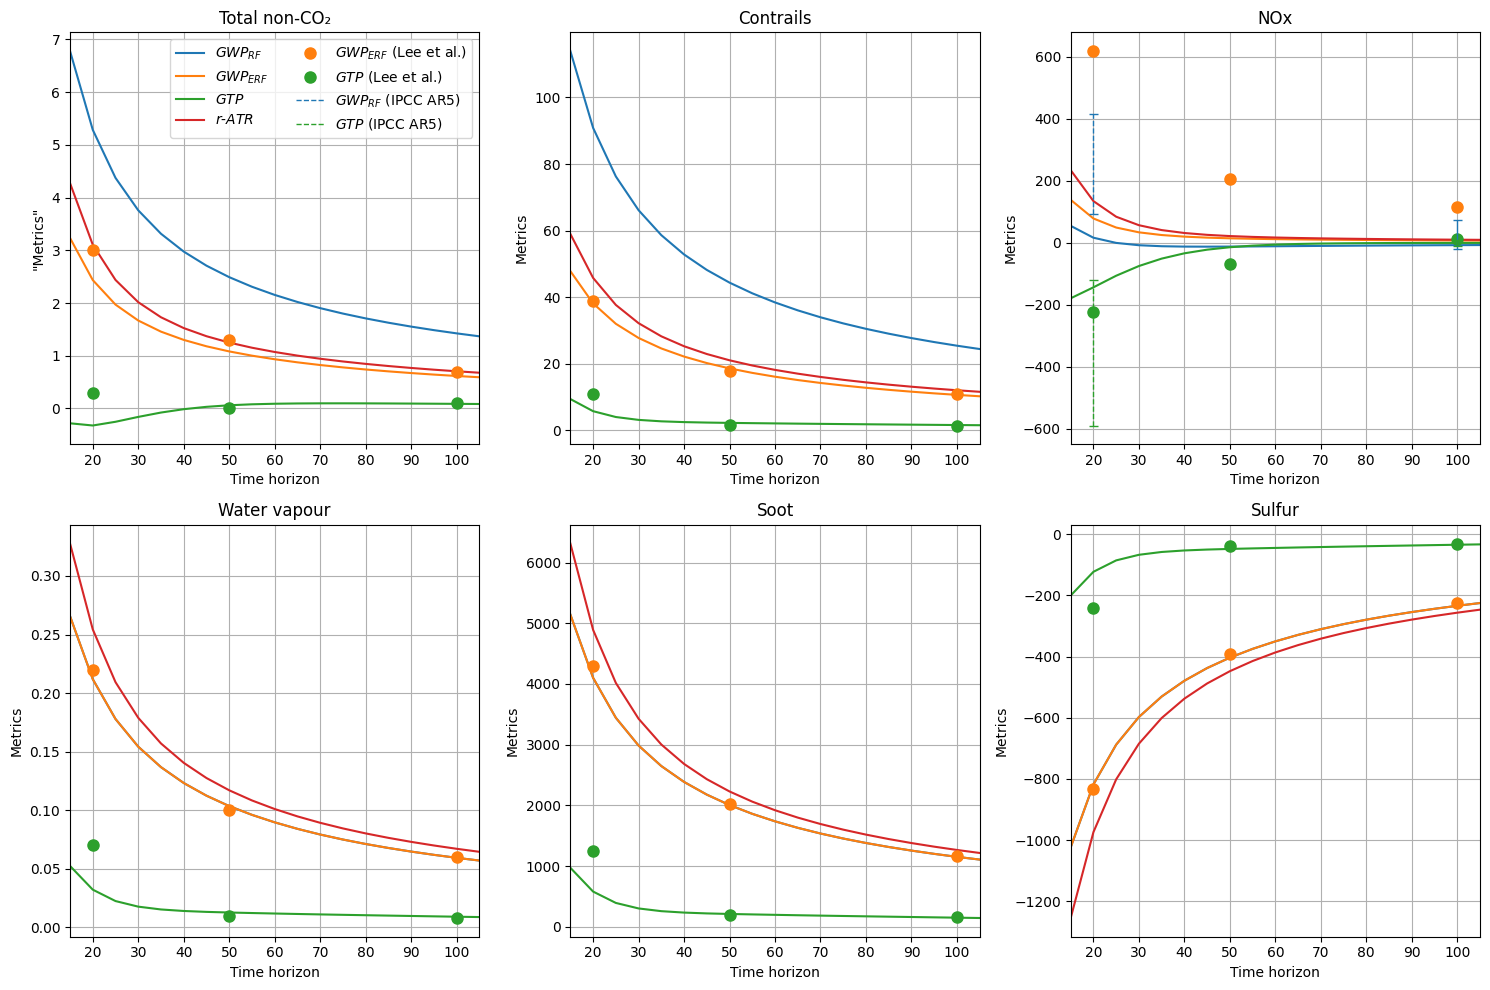

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k = 0

# Ratio based on 2018 data
ratio_contrails = 61.3/1033.7 # Million km / MtCO2
ratio_nox = 1.4*46/14/1033.7 # MtNOx / MtCO2
ratio_h2o = 382.55/1033.7 # MtH2O / MtCO2
ratio_soot = 0.0093/1033.7 # MtBC / MtCO2
ratio_sulfur = 0.37/1033.7 # MtSOx / MtCO2

for i, ax in enumerate(axes.flat):
    if i == 0:
        x_axis = time_horizon_range
        ax.plot(x_axis, ratio_contrails*gwp_rf[:, i+0]+ratio_nox*(gwp_rf[:, i+2]+gwp_rf[:, i+1])+ratio_h2o*gwp_rf[:, i+3]+ratio_soot*gwp_rf[:, i+4]+ratio_sulfur*gwp_rf[:, i+5], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, ratio_contrails*gwp_erf[:, i+0]+ratio_nox*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o*gwp_erf[:, i+3]+ratio_soot*gwp_erf[:, i+4]+ratio_sulfur*gwp_erf[:, i+5], label=r'$GWP_{ERF}$', color='C1')
        ax.plot(x_axis, ratio_contrails*gtp[:, i+0]+ratio_nox*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o*gtp[:, i+3]+ratio_soot*gtp[:, i+4]+ratio_sulfur*gtp[:, i+5], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratio_contrails*ratr[:, i+0]+ratio_nox*(ratr[:, i+2]+ratr[:, i+1])+ratio_h2o*ratr[:, i+3]+ratio_soot*ratr[:, i+4]+ratio_sulfur*ratr[:, i+5], label=r'$r\text{-}ATR$', color='C3')
        ax.plot(20, 3, marker="o", color="C1", markersize=8, label=r'$GWP_{ERF}$ (Lee et al.)', linestyle="None")
        ax.plot(50, 1.3, marker="o", color="C1", markersize=8)
        ax.plot(100, 0.7, marker="o", color="C1", markersize=8)
        ax.plot(20, 0.3, marker="o", color="C2", markersize=8, label=r'$GTP$ (Lee et al.)', linestyle="None")
        ax.plot(50, 0.0, marker="o", color="C2", markersize=8)
        ax.plot(100, 0.1, marker="o", color="C2", markersize=8)
        ax.vlines(x=10, ymin=0, ymax=1, color="C0", linewidth=1, label=r'$GWP_{RF}$ (IPCC AR5)', linestyle="--")
        ax.vlines(x=110, ymin=0, ymax=1, color="C2", linewidth=1, label=r'$GTP$ (IPCC AR5)', linestyle="--")
        ax.legend(ncol=2)
    elif i == 1:
        ax.plot(x_axis, gwp_rf[:, i-1], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i-1], label=r'$GWP_{ERF}$', color='C1')
        ax.plot(x_axis, gtp[:, i-1], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i-1], label=r'$r\text{-}ATR$', color='C3')
        ax.plot(20, 39, marker="o", color="C1", markersize=8, label=r'$GWP_{ERF}$ (Lee et al.)')
        ax.plot(50, 18, marker="o", color="C1", markersize=8)
        ax.plot(100, 11, marker="o", color="C1", markersize=8)
        ax.plot(20, 11, marker="o", color="C2", markersize=8, label=r'$GTP$ (Lee et al.)')
        ax.plot(50, 1.8, marker="o", color="C2", markersize=8)
        ax.plot(100, 1.5, marker="o", color="C2", markersize=8)
    elif i == 2:
        ax.plot(x_axis, gwp_rf[:, i-1]+gwp_rf[:, i], color='C0')
        ax.plot(x_axis, gwp_erf[:, i-1]+gwp_erf[:, i], color='C1')
        ax.plot(x_axis, gtp[:, i-1]+gtp[:, i], color='C2')
        ax.plot(x_axis, ratr[:, i-1]+ratr[:, i], color='C3')
        ax.plot(20, 619, marker="o", color="C1", markersize=8, label=r'$GWP_{ERF}$ (Lee et al.)')
        ax.plot(50, 205, marker="o", color="C1", markersize=8)
        ax.plot(100, 114, marker="o", color="C1", markersize=8)
        ax.plot(20, -222, marker="o", color="C2", markersize=8, label=r'$GTP$ (Lee et al.)')
        ax.plot(50, -69, marker="o", color="C2", markersize=8)
        ax.plot(100, 13, marker="o", color="C2", markersize=8)
        ax.vlines(x=20, ymin=92, ymax=415, color="C0", linewidth=1, label=r'$GWP_{RF}$ (IPCC AR5)', linestyle="--")
        ax.hlines(y=92, xmin=19, xmax=21, color="C0", linewidth=1)
        ax.hlines(y=415, xmin=19, xmax=21, color="C0", linewidth=1)
        ax.vlines(x=100, ymin=-21, ymax=75, color="C0", linewidth=1)
        ax.hlines(y=-21, xmin=99, xmax=101, color="C0", linewidth=1)
        ax.hlines(y=75, xmin=99, xmax=101, color="C0", linewidth=1)
        ax.vlines(x=20, ymin=-590, ymax=-121, color="C2", linewidth=1, label=r'$GTP$ (IPCC AR5)', linestyle="--")
        ax.hlines(y=-590, xmin=19, xmax=21, color="C2", linewidth=1)
        ax.hlines(y=-121, xmin=19, xmax=21, color="C2", linewidth=1)
        ax.vlines(x=100, ymin=-9.5, ymax=8.6, color="C2", linewidth=1)
        ax.hlines(y=-9.5, xmin=99, xmax=101, color="C2", linewidth=1)
        ax.hlines(y=8.6, xmin=99, xmax=101, color="C2", linewidth=1)
        #ax.set_yscale('symlog', linthresh=10)
    else:
        x_axis = time_horizon_range
        ax.plot(x_axis, gwp_rf[:, i], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i], label=r'$GWP_{ERF}$', color='C1')
        ax.plot(x_axis, gtp[:, i], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i], label=r'$r\text{-}ATR$', color='C3')
        if i==3:
            ax.plot(20, 0.22, marker="o", color="C1", markersize=8, label=r'$GWP_{ERF}$ (Lee et al.)')
            ax.plot(50, 0.1, marker="o", color="C1", markersize=8)
            ax.plot(100, 0.06, marker="o", color="C1", markersize=8)
            ax.plot(20, 0.07, marker="o", color="C2", markersize=8, label=r'$GTP$ (Lee et al.)')
            ax.plot(50, 0.01, marker="o", color="C2", markersize=8)
            ax.plot(100, 0.008, marker="o", color="C2", markersize=8)
        elif i==4:
            ax.plot(20, 4288, marker="o", color="C1", markersize=8, label=r'$GWP_{ERF}$ (Lee et al.)')
            ax.plot(50, 2018, marker="o", color="C1", markersize=8)
            ax.plot(100, 1166, marker="o", color="C1", markersize=8)
            ax.plot(20, 1245, marker="o", color="C2", markersize=8, label=r'$GTP$ (Lee et al.)')
            ax.plot(50, 195, marker="o", color="C2", markersize=8)
            ax.plot(100, 161, marker="o", color="C2", markersize=8)
        else:
            ax.plot(20, -832, marker="o", color="C1", markersize=8, label=r'$GWP_{ERF}$ (Lee et al.)')
            ax.plot(50, -392, marker="o", color="C1", markersize=8)
            ax.plot(100, -226, marker="o", color="C1", markersize=8)
            ax.plot(20, -241, marker="o", color="C2", markersize=8, label=r'$GTP$ (Lee et al.)')
            ax.plot(50, -38, marker="o", color="C2", markersize=8)
            ax.plot(100, -31, marker="o", color="C2", markersize=8)
    ax.set_xlim(min(time_horizon_range),max(time_horizon_range))
    ax.set_xlabel('Time horizon')
    if i == 0:
        ax.set_ylabel('"Metrics"')
    else:
        ax.set_ylabel('Metrics')
    ax.grid(True)
    if i == 0:
        ax.set_title('Total non-CO₂')
    elif i == 1:
        ax.set_title('Contrails')
    elif i == 2:
        ax.set_title('NOx')
    elif i == 3:
        ax.set_title('Water vapour')
    elif i == 4:
        ax.set_title('Soot')
    elif i == 5:
        ax.set_title('Sulfur')

plt.tight_layout()
plt.savefig("fig1.pdf")
plt.show()